In [1]:
from abc import ABC, abstractmethod
from datetime import datetime
from datetime import timedelta
from collections import defaultdict
from timeit import default_timer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import os
import random

In [2]:
class Dataset(ABC):
    @staticmethod
    @abstractmethod
    def load():
        """ Every subclass must provide static load method"""
        pass


class MovieLensDataset(Dataset):
    def __init__(self,
                 ratings_col_names=('user_id', 'item_id', 'rating', 'timestamp'),
                 ratings_path=r'C:\Users\Yukawa\datasets\ml-latest-small\ratings.csv',
                 movies_col_names=('item_id', 'title', 'genres'),
                 movies_path=r'C:\Users\Yukawa\datasets\ml-latest-small\movies.csv',
                 is_ratings_cached=False,
                 is_movies_cached=False):
        Dataset.__init__(self)
        # In case we dont want to use Cache class, we can cache movies and ratings here as well.
        self.is_ratings_cached = is_ratings_cached
        self.is_movies_cached = is_movies_cached
        self.ratings = MovieLensDataset.load_ratings(ratings_path,
                                                     ratings_col_names) if self.is_ratings_cached else None
        self.movies = MovieLensDataset.load_movies(movies_path,
                                                   movies_col_names) if self.is_movies_cached else None

    @staticmethod
    def load_movies(movies_path,
                    movies_col_names=('item_id', 'title', 'genres')):
        if not os.path.isfile(movies_path) or not movies_col_names:
            return None

        # read movies
        movies = pd.read_csv(movies_path, sep=',', header=1, names=movies_col_names)

        # Extract Movie Year
        movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
        movies.year = pd.to_datetime(movies.year, format='%Y')
        movies.year = movies.year.dt.year  # As there are some NaN years, resulting type will be float (decimals)

        # Remove year part from the title
        movies.title = movies.title.str[:-7]

        return movies

    @staticmethod
    def load_ratings(ratings_path,
                     ratings_col_names=('user_id', 'item_id', 'rating', 'timestamp')):
        if not os.path.isfile(ratings_path) or not ratings_col_names:
            return None

        # read ratings
        ratings = pd.read_csv(ratings_path, sep=',', header=1, names=ratings_col_names)

        # Convert timestamp into readable format
        ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s', origin='unix')

        return ratings

    @staticmethod
    def create_movie_ratings(ratings, movies):
        return pd.merge(ratings, movies, on='item_id')

    @staticmethod
    def load(ratings_col_names=('user_id', 'item_id', 'rating', 'timestamp'),
             ratings_path=r'C:\Users\Yukawa\datasets\ml-latest-small\ratings.csv',
             movies_col_names=('item_id', 'title', 'genres'),
             movies_path=r'C:\Users\Yukawa\datasets\ml-latest-small\movies.csv'
             ):
        # Load movies
        movies = MovieLensDataset.load_movies(movies_path=movies_path, movies_col_names=movies_col_names)
        # Load ratings
        ratings = MovieLensDataset.load_ratings(ratings_path=ratings_path, ratings_col_names=ratings_col_names)

        # Merge the ratings and movies
        movie_ratings = pd.merge(ratings, movies, on='item_id')

        return movie_ratings

In [3]:
dataset = MovieLensDataset(is_movies_cached=True, is_ratings_cached=True)

In [4]:
dataset.movies.head()

,item_id,title,genres,year
0,2,Jumanji,Adventure|Children|Fantasy,1995.0
1,3,Grumpier Old Men,Comedy|Romance,1995.0
2,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
3,5,Father of the Bride Part II,Comedy,1995.0
4,6,Heat,Action|Crime|Thriller,1995.0


In [5]:
dataset.ratings.head()

,user_id,item_id,rating,timestamp
0,1,3,4.0,2000-07-30 18:20:47
1,1,6,4.0,2000-07-30 18:37:04
2,1,47,5.0,2000-07-30 19:03:35
3,1,50,5.0,2000-07-30 18:48:51
4,1,70,3.0,2000-07-30 18:40:00


In [6]:
class TimeConstraint:

    def __init__(self, end_dt, start_dt=None):
        """
        When end_dt is only given, TimeConstraint will be of type max limit.

        When start_dt and end_dt are given, TimeConstraint will be of type time bin.

        :param end_dt: The end time.
        :param start_dt: The start time.
            Always set start_dt to None if you change the object from time_bin to max_limit.
        """
        self.end_dt = end_dt
        self.start_dt = start_dt
        

    def is_valid_max_limit(self) -> bool:
        """
        Check whether the object is of max time limit type.
        """
        if (self._end_dt is not None) and (self._start_dt is None):
            return True

    def is_valid_time_bin(self) -> bool:
        """
        Check whether the object is of time bin type. 
        """
        if (self._start_dt is not None) and (self._end_dt is not None):
            return True
        return False

    # Comparing TimeConstraints

    def __eq__(self, other):
        if other is None:
            return False
        return self._start_dt == other.start_dt and self._end_dt == other.end_dt

    def __ne__(self, other):
        if other is None:
            return False
        return self._start_dt != other.start_dt or self._end_dt != other.end_dt

    # Properties

    @property
    def end_dt(self):
        return self._end_dt

    @end_dt.setter
    def end_dt(self, value):
        self._end_dt = value

    @property
    def start_dt(self):
        return self._start_dt

    @start_dt.setter
    def start_dt(self, value):
        self._start_dt = value

    # Printing TimeConstraints

    def __repr__(self):
        return f"(start = {self._start_dt}, end= {self._end_dt})"

    def __str__(self):
        return f"(start = {self._start_dt}, end= {self._end_dt})"


In [7]:
def get_movies_watched(ratings, user_id: int, time_constraint: TimeConstraint = None) -> pd.DataFrame:
    """
    Get all the movies watched by the chosen user.

    :param user_id: the user that we want to get the movies he-she has watched.
    :param time_constraint: type of the time constraint.
    :return: DataFrame of all movies watched with 'item_id', 'rating' columns
    """

    movie_ratings = ratings
    
    if time_constraint is None:
        return movie_ratings.loc[(movie_ratings['user_id'] == user_id)][['item_id', 'rating', 'timestamp']].set_index('item_id')

    if time_constraint.is_valid_max_limit():
        return movie_ratings.loc[(movie_ratings['user_id'] == user_id)
                                 & (movie_ratings.timestamp < time_constraint.end_dt)][['item_id', 'rating', 'timestamp']].set_index('item_id')
    elif time_constraint.is_valid_time_bin():
        return movie_ratings.loc[(movie_ratings['user_id'] == user_id)
                                 & (movie_ratings.timestamp >= time_constraint.start_dt)
                                 & (movie_ratings.timestamp < time_constraint.end_dt)][['item_id', 'rating', 'timestamp']].set_index('item_id')
    raise Exception("Undefined time_constraint is given!")

In [8]:
def get_avg_rating(user_id):
    return dataset.ratings.groupby('user_id')[['rating']].mean().loc[user_id][0]

In [9]:
def find_timebin_corr(ratings, timebin, avg_rating, user_id, timebin_time_constraint):
    curr_bin = get_movies_watched(ratings, user_id, timebin_time_constraint)
    merged = curr_bin.merge(timebin, on='item_id')
    common_elements = len(merged)
    
    user_avg_rating = get_avg_rating(user_id)
    numenator = ((merged['rating_x'] - avg_rating) * (merged['rating_y'] - user_avg_rating)).sum()
    denominator = math.sqrt(((merged['rating_x'] - avg_rating) ** 2).sum())
    denominator *= math.sqrt(((merged['rating_y'] - user_avg_rating) ** 2).sum())
    pearson = numenator / denominator
    
    return pearson, common_elements

## Choose Timebin in order to find similar ones later

In [10]:
avg_rating=get_avg_rating(443)  # avg rating of timebin owner user
timebin_constraint = TimeConstraint(start_dt=datetime(year=2017, month=1, day=1), end_dt=datetime.now())
timebin_size_in_days = abs((datetime(year=2017, month=1, day=1) - datetime.now()).days)
timebin = get_movies_watched(dataset.ratings, 443, timebin_constraint)
timebin

,rating,timestamp
item_id,,
1,4.0,2017-08-03 01:08:02
110,4.5,2017-08-03 01:07:57
260,4.0,2017-08-03 01:07:45
296,4.0,2017-08-03 01:07:47
318,5.0,2017-08-03 01:07:38
356,5.0,2017-08-03 01:07:41
608,5.0,2017-08-03 01:08:15
5952,5.0,2017-08-03 01:08:17
7153,5.0,2017-08-03 01:08:18


In [11]:
timebin_size_in_days

1233

## Define Limits

In [12]:
first_timestamp = dataset.ratings['timestamp'].min()
first_timestamp

Timestamp('1996-03-29 18:36:55')

In [13]:
max_timebin_size_in_days = abs((first_timestamp - datetime.now()).days)
max_timebin_size_in_days

8816

## Find Users Who Has Rated at Least  5 Movies In Common

In [14]:
# Userlist-->for each user number of movies watched in common with the 'timebin'
userlist = [0 for i in range(611)]
for movie_id in timebin.index.values.tolist():
    for user_who_watched in dataset.ratings.loc[(dataset.ratings['item_id'] == movie_id)][['user_id']].values.tolist():
        userlist[user_who_watched[0]] += 1
print(userlist)

[0, 5, 2, 0, 3, 5, 5, 5, 4, 1, 4, 3, 0, 0, 4, 7, 8, 9, 10, 3, 1, 8, 3, 2, 5, 4, 2, 3, 8, 3, 6, 1, 5, 6, 4, 0, 1, 3, 4, 3, 4, 6, 5, 5, 2, 5, 3, 2, 0, 4, 6, 1, 5, 0, 5, 0, 4, 6, 4, 3, 1, 3, 9, 10, 9, 3, 9, 6, 10, 4, 2, 3, 5, 3, 2, 3, 9, 4, 6, 1, 2, 4, 5, 6, 5, 0, 7, 0, 4, 2, 3, 9, 0, 5, 4, 3, 4, 0, 5, 2, 2, 0, 3, 10, 5, 10, 3, 4, 1, 4, 3, 4, 7, 2, 1, 3, 1, 5, 2, 8, 2, 5, 6, 6, 7, 7, 4, 0, 3, 4, 4, 9, 8, 4, 3, 6, 2, 9, 0, 4, 9, 8, 2, 2, 6, 3, 0, 0, 4, 1, 1, 1, 5, 3, 2, 2, 6, 0, 0, 5, 8, 2, 4, 0, 1, 2, 8, 9, 3, 5, 4, 5, 0, 3, 2, 0, 3, 9, 8, 6, 1, 3, 9, 1, 1, 2, 2, 8, 1, 5, 2, 5, 3, 6, 0, 4, 2, 3, 6, 5, 8, 4, 7, 5, 1, 3, 2, 0, 1, 5, 4, 6, 8, 3, 1, 7, 1, 6, 1, 7, 8, 4, 5, 7, 2, 0, 7, 7, 2, 5, 3, 3, 9, 9, 2, 4, 0, 2, 0, 9, 5, 2, 2, 1, 2, 0, 6, 10, 1, 11, 1, 4, 2, 1, 8, 0, 2, 1, 1, 0, 2, 4, 4, 7, 4, 4, 6, 2, 2, 1, 2, 0, 1, 3, 10, 7, 3, 2, 1, 10, 3, 0, 6, 5, 4, 1, 5, 3, 9, 0, 5, 2, 10, 2, 4, 3, 5, 1, 11, 0, 3, 4, 4, 1, 6, 9, 0, 9, 7, 4, 0, 0, 5, 4, 6, 0, 1, 7, 9, 4, 0, 1, 6, 7, 1, 3, 7, 2, 10, 

In [15]:
user_id_list = []
for i in range(0, 611):
    if userlist[i] > 5:
        user_id_list.append(i)
user_id_list

[15,
 16,
 17,
 18,
 21,
 28,
 30,
 33,
 41,
 50,
 57,
 62,
 63,
 64,
 66,
 67,
 68,
 76,
 78,
 83,
 86,
 91,
 103,
 105,
 112,
 119,
 122,
 123,
 124,
 125,
 131,
 132,
 135,
 137,
 140,
 141,
 144,
 156,
 160,
 166,
 167,
 177,
 178,
 179,
 182,
 187,
 193,
 198,
 200,
 202,
 211,
 212,
 215,
 217,
 219,
 220,
 223,
 226,
 227,
 232,
 233,
 239,
 246,
 247,
 249,
 254,
 263,
 266,
 274,
 275,
 279,
 282,
 288,
 292,
 298,
 304,
 305,
 307,
 308,
 314,
 317,
 318,
 322,
 323,
 326,
 328,
 330,
 331,
 332,
 334,
 336,
 339,
 348,
 352,
 357,
 362,
 365,
 370,
 372,
 376,
 380,
 381,
 382,
 385,
 387,
 391,
 399,
 400,
 414,
 415,
 416,
 417,
 418,
 420,
 425,
 428,
 432,
 434,
 437,
 438,
 443,
 445,
 448,
 453,
 460,
 462,
 464,
 466,
 469,
 470,
 474,
 477,
 480,
 483,
 489,
 490,
 497,
 509,
 513,
 514,
 517,
 522,
 525,
 534,
 551,
 555,
 559,
 560,
 561,
 562,
 567,
 570,
 573,
 580,
 590,
 593,
 596,
 599,
 600,
 602,
 603,
 605,
 606,
 607,
 608,
 610]

## Find Similar Time Bins

In [16]:
data = list()
start_time = default_timer()
for timebin_size in range(timebin_size_in_days, max_timebin_size_in_days, timebin_size_in_days):
    for shift in range(0, timebin_size, timebin_size//10):    # make 10 start time shift
        start_dt = first_timestamp + timedelta(days=shift)   # assign start time 
        curr_dt = start_dt
        while (curr_dt + timedelta(days=timebin_size)) < datetime.now():
            for user_id in user_id_list:   # user_id_list contains users who has watched the movies in common
                end_dt = curr_dt + timedelta(days=timebin_size)
                # find curr_timebin
                timebin_time_constraint = TimeConstraint(start_dt=curr_dt, end_dt=end_dt)
                corr, common_elements = find_timebin_corr(dataset.ratings, timebin=timebin, avg_rating=avg_rating, 
                                         user_id=user_id, timebin_time_constraint=timebin_time_constraint)
                # if and only if more than 3 movies in common rated in the temporal time bin, get the correlations
                if not math.isnan(corr) and common_elements > 3:
                    data.append( (user_id, curr_dt, timebin_size, corr) )
            curr_dt = end_dt                        #curr_dt + timedelta(days=timebin_size)
            #print(f"start={start_dt} -  curr={curr_dt}, shift={shift}, timebin_size ={timebin_size}")
runtime = default_timer() - start_time
print(f"runtime={runtime}")

C:\Users\Yukawa\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


runtime=187.37524069999998


In [17]:
df = pd.DataFrame(data, columns=['user_id', 'start_dt', 'bin_size_in_days', 'pearson_corr'])
df

,user_id,start_dt,bin_size_in_days,pearson_corr
0,179,1996-03-29 18:36:55,1233,0.743588
1,304,1996-03-29 18:36:55,1233,0.513369
2,314,1996-03-29 18:36:55,1233,-0.152215
3,372,1996-03-29 18:36:55,1233,0.003930
4,385,1996-03-29 18:36:55,1233,0.640314
...,...,...,...,...
6027,605,1996-03-29 18:36:55,8631,-0.125193
6028,606,1996-03-29 18:36:55,8631,-0.102029
6029,607,1996-03-29 18:36:55,8631,-0.250011
6030,608,1996-03-29 18:36:55,8631,-0.364311


In [18]:
timebin_similarities = df.sort_values(by='pearson_corr', ascending=False).drop_duplicates('user_id').set_index('user_id')
timebin_similarities.loc[timebin_similarities['pearson_corr'] > 0.5]

,start_dt,bin_size_in_days,pearson_corr
user_id,,,
443,2015-10-25 18:36:55,1233,1.000000
464,2004-05-04 18:36:55,2466,0.931849
414,1996-03-29 18:36:55,2466,0.919222
474,2000-12-18 18:36:55,1233,0.917120
232,2006-05-12 18:36:55,1233,0.910353
555,2000-04-13 18:36:55,2466,0.894879
469,1996-03-29 18:36:55,7398,0.869476
166,2000-12-15 18:36:55,2466,0.799545
239,1999-04-10 18:36:55,3699,0.793097


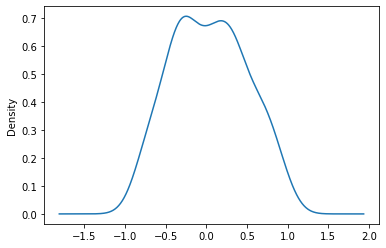

In [19]:
timebin_similarities['pearson_corr'].plot(kind='density')

In [20]:
start_dt = datetime(2004,5,4)
find_timebin_corr(dataset.ratings, timebin=timebin, avg_rating=get_avg_rating(443), user_id=464, 
                  timebin_time_constraint=TimeConstraint(start_dt=start_dt, end_dt=start_dt + timedelta(days=2466)))

(0.9318488622690376, 7)

In [21]:
watched_by_464 = get_movies_watched(dataset.ratings, 464, TimeConstraint(start_dt=start_dt, end_dt=start_dt + timedelta(days=2466)))
watched_by_464

,rating,timestamp
item_id,,
9,2.5,2010-10-18 11:08:04
16,4.5,2010-10-18 11:12:36
20,4.0,2010-06-03 06:55:42
23,3.0,2010-06-03 06:55:30
25,4.0,2010-10-18 11:10:27
...,...,...
58559,3.5,2010-06-03 07:08:51
60069,2.0,2010-10-18 10:44:20
62956,2.0,2010-09-19 09:07:19


In [22]:
watched_by_464.merge(timebin, on='item_id')

,rating_x,timestamp_x,rating_y,timestamp_y
item_id,,,,
110,5.0,2010-06-03 07:08:31,4.5,2017-08-03 01:07:57
260,5.0,2010-06-03 07:04:39,4.0,2017-08-03 01:07:45
296,4.5,2010-06-03 07:18:38,4.0,2017-08-03 01:07:47
318,5.0,2010-10-18 10:51:42,5.0,2017-08-03 01:07:38
356,5.0,2010-10-18 10:51:18,5.0,2017-08-03 01:07:41
5952,5.0,2010-06-03 07:16:32,5.0,2017-08-03 01:08:17
7153,5.0,2010-06-03 07:16:19,5.0,2017-08-03 01:08:18
